## Libraries

In [0]:
import os
import time
from google.colab import drive
import tensorflow as tf
import pickle
import math
import pandas as pd
import numpy as np
import zipfile

### Mounting Drive

In [0]:
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
!ls 'gdrive/My Drive/DrivenData/Data'

final_max_values.csv	 submission_format.csv	 test_values.zip
final_mean_values.csv	 test_max_values.csv	 train_labels.csv
final_median_values.csv  test_mean_values.csv	 train_values.csv
final_std_values.csv	 test_median_values.csv  train_values.zip
mean_values.csv		 test_std_values.csv
recipe_metadata.csv	 test_values.csv


## Data Loading

### Functions

In [0]:
def read_csv_from_zip(zip_path, data_file, is_tsv = False):

  archive = zipfile.ZipFile(zip_path, 'r')
  if( is_tsv ):
    data = pd.read_csv(archive.open(data_file),delimiter='\t')#,header=None)
  else:
    data = pd.read_csv(archive.open(data_file))#,header=None)
  print("Null values in Data: ", data.isnull().values.any())
  print(data.head())
  return data


def read_csv(file, is_tsv = False):
  if( is_tsv ):
    data = pd.read_csv(file,delimiter='\t')#,header=None)
  else:
    data = pd.read_csv(file)#,header=None)
  print("Null values in Data: ", data.isnull().values.any())
  print(data.head())
  return data

### Loading

In [0]:
zip_path  = "gdrive/My Drive/DrivenData/Data/train_values.zip"
data_file  = "train_values.csv"

train_df = read_csv_from_zip(zip_path,data_file)

Null values in Data:  False
   row_id  process_id  object_id      phase            timestamp pipeline  \
0       0       20001        405  pre_rinse  2018-04-15 04:20:47       L4   
1       1       20001        405  pre_rinse  2018-04-15 04:20:49       L4   
2       2       20001        405  pre_rinse  2018-04-15 04:20:51       L4   
3       3       20001        405  pre_rinse  2018-04-15 04:20:53       L4   
4       4       20001        405  pre_rinse  2018-04-15 04:20:55       L4   

   supply_flow  supply_pressure  return_temperature  return_conductivity  \
0     8550.348         0.615451           18.044704             4.990765   
1    11364.294         0.654297           18.229168             3.749680   
2    12174.479         0.699870           18.395544             2.783954   
3    13436.776         0.761502           18.583622             1.769353   
4    13776.766         0.837240           18.627026             0.904020   

          ...          tank_temperature_pre_rinse  t

In [0]:
train_df.columns

Index(['row_id', 'process_id', 'object_id', 'phase', 'timestamp', 'pipeline',
       'supply_flow', 'supply_pressure', 'return_temperature',
       'return_conductivity', 'return_turbidity', 'return_flow', 'supply_pump',
       'supply_pre_rinse', 'supply_caustic', 'return_caustic', 'supply_acid',
       'return_acid', 'supply_clean_water', 'return_recovery_water',
       'return_drain', 'object_low_level', 'tank_level_pre_rinse',
       'tank_level_caustic', 'tank_level_acid', 'tank_level_clean_water',
       'tank_temperature_pre_rinse', 'tank_temperature_caustic',
       'tank_temperature_acid', 'tank_concentration_caustic',
       'tank_concentration_acid', 'tank_lsh_caustic', 'tank_lsh_acid',
       'tank_lsh_clean_water', 'tank_lsh_pre_rinse', 'target_time_period'],
      dtype='object')

In [0]:
#train_df.loc[200:300,[1,2,3,4,5,35]]
train_df['supply_flow'][:10]

0     8550.348
1    11364.294
2    12174.479
3    13436.776
4    13776.766
5    18710.215
6    21216.725
7    22403.066
8    23278.357
9    24178.965
Name: supply_flow, dtype: float64

In [0]:
zip_path  = "gdrive/My Drive/DrivenData/Data/"
data_file  = "train_labels.csv"

labels_df = read_csv(zip_path+data_file)

Null values in Data:  False
   process_id  final_rinse_total_turbidity_liter
0       20001                       4.318275e+06
1       20002                       4.375286e+05
2       20003                       4.271977e+05
3       20004                       7.197830e+05
4       20005                       4.133107e+05


In [0]:
zip_path  = "gdrive/My Drive/DrivenData/Data/"
data_file  = "recipe_metadata.csv"

meta_df = read_csv(zip_path+data_file)

Null values in Data:  False
   process_id  pre_rinse  caustic  intermediate_rinse  acid  final_rinse
0       20000          1        1                   1     1            1
1       20001          1        1                   1     1            1
2       20002          1        1                   0     0            1
3       20003          1        1                   1     1            1
4       20004          1        1                   1     1            1


In [0]:
zip_path  = "gdrive/My Drive/DrivenData/Data/"
data_file  = "submission_format.csv"

sub_df = read_csv(zip_path+data_file)

Null values in Data:  False
   process_id  final_rinse_total_turbidity_liter
0       20000                                1.0
1       20006                                1.0
2       20007                                1.0
3       20009                                1.0
4       20010                                1.0


In [0]:
zip_path  = "gdrive/My Drive/DrivenData/Data/test_values.zip"
data_file  = "test_values.csv"

test_df = read_csv_from_zip(zip_path,data_file)

Null values in Data:  False
   row_id  process_id  object_id      phase            timestamp pipeline  \
0       0       20000        427  pre_rinse  2018-04-30 21:39:21       L4   
1       1       20000        427  pre_rinse  2018-04-30 21:39:23       L4   
2       2       20000        427  pre_rinse  2018-04-30 21:39:25       L4   
3       3       20000        427  pre_rinse  2018-04-30 21:39:27       L4   
4       4       20000        427  pre_rinse  2018-04-30 21:39:29       L4   

   supply_flow  supply_pressure  return_temperature  return_conductivity  \
0    17039.207         0.480035           13.726129             0.337567   
1    29390.912         0.554253           13.852720             0.335876   
2    24323.640         0.657118           13.939526             0.335706   
3    17180.266         0.749132           14.001014             0.335571   
4    11754.919         0.795139           14.001014             0.335509   

          ...          tank_temperature_pre_rinse  t

## Prophet

In [0]:
import pandas as pd
!pip3 install fbprophet
from fbprophet import Prophet

### Data Preparation



In [0]:
df  =  train_df[['timestamp','process_id', 'phase','target_time_period', 'return_turbidity','return_flow']].copy(deep=True)
df.head()

,timestamp,process_id,phase,target_time_period,return_turbidity,return_flow
0,2018-04-15 04:20:47,20001,pre_rinse,False,0.177228,15776.9100
1,2018-04-15 04:20:49,20001,pre_rinse,False,0.122975,13241.4640
2,2018-04-15 04:20:51,20001,pre_rinse,False,0.387008,10698.7850
3,2018-04-15 04:20:53,20001,pre_rinse,False,0.213397,8007.8125
4,2018-04-15 04:20:55,20001,pre_rinse,False,0.148293,6004.0510


In [0]:
len(df['process_id'].unique())

5021

In [0]:
df_sample = df[df['process_id']==20000]
df_sample.head()

,timestamp,process_id,phase,target_time_period,return_turbidity,return_flow


In [0]:
df_sample['phase'].unique()

array([], dtype=object)

In [0]:
train =  df_sample[ df_sample['phase'] == 'acid' ] 

In [0]:
#train =  df_sample[df_sample['target_time_period'] == False ] 
#test =  df_sample[df_sample['target_time_period'] == True ] 
train.head()

,timestamp,process_id,phase,target_time_period,return_turbidity,return_flow


In [0]:
train.mean()

timestamp            NaN
process_id           NaN
phase                NaN
target_time_period   NaN
return_turbidity     NaN
return_flow          NaN
dtype: float64

In [0]:
test.head()

,timestamp,process_id,target_time_period,return_turbidity,return_flow


In [0]:
# df = pd.DataFrame()
# df['ds']  = train_df['timestamp'][:200]
# df['y'] = train_df['supply_flow'][:200]
# df.head()

,ds,y
0,2018-04-15 04:20:47,8550.348
1,2018-04-15 04:20:49,11364.294
2,2018-04-15 04:20:51,12174.479
3,2018-04-15 04:20:53,13436.776
4,2018-04-15 04:20:55,13776.766


In [0]:
def prophet (train, test , columns):
  
  df = pd.DataFrame()
  df['ds']  = train[columns[0]]
  df['y'] = train[columns[1]]
  
  m = Prophet()
  m.fit(df)
  
  #df_test = pd.DataFrame()
  #df_test['ds']  = test[columns[0]]
  #df_test['y'] = test[columns[1]]
  future = m.make_future_dataframe(periods=(int)(len(train)/10))
  
  forecast = m.predict(future)
  print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
  return forecast


In [0]:
columns = ['timestamp','return_turbidity']
turb  = prophet(train,columns)
columns = ['timestamp','return_flow']
flow  = prophet(train,columns)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KeyboardInterrupt: ignored

In [0]:
df_sample = df[df['process_id']==20000]

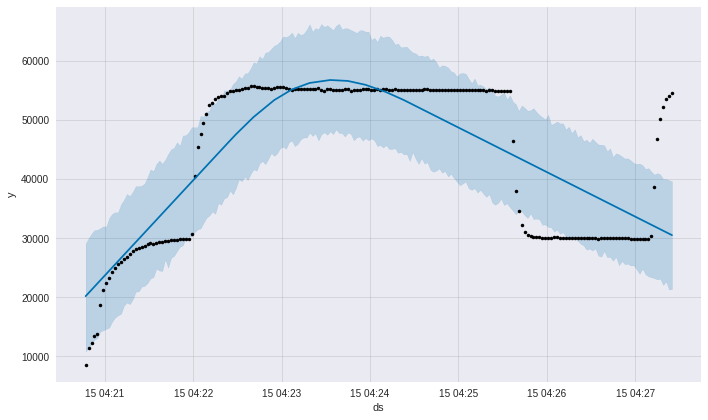

In [0]:
fig1 = m.plot(forecast)


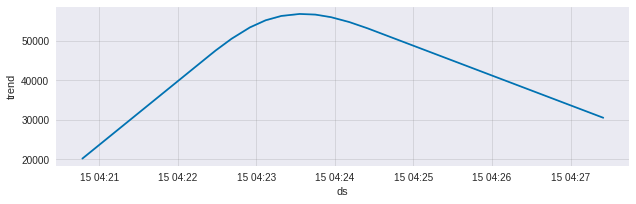

In [0]:
fig2 = m.plot_components(forecast)

## Models

In [0]:
zip_path  = "gdrive/My Drive/DrivenData/Data/"
data_file  = "mean_values.csv"

df = read_csv(zip_path+data_file)

Null values in Data:  False
   process_id          0         1          2         3          4  \
0       20001  55674.910  2.223741  33.658850  4.990765  45.026764   
1       20002  31933.594  1.768880  52.365450  0.517570   0.665509   
2       20003  42552.810  3.859375  46.401188  5.793418  60.394966   
3       20004  49537.035  0.482422  28.653067  2.917131  32.150608   
4       20005      0.000  0.000000   0.000000  0.000000   0.000000   

            5          6          7          8      ...              51  \
0  60206.8830  55.499672  41.654730  44.092700      ...       55.955765   
1   7595.4863  53.052300  45.371635  41.729960      ...        0.000000   
2  61631.9400  56.567020  46.829247  45.757200      ...       56.520000   
3  48283.7800  54.688583  44.816803  42.874893      ...       54.467594   
4      0.0000   0.000000   0.000000   0.000000      ...       56.338974   

          52         53         54         55         56         57  \
0  43.674225  43.161713  42.1

In [0]:
x = df.iloc[:,1:61]
y = df.iloc[:,61]
x.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,55674.910,2.223741,33.658850,4.990765,45.026764,60206.8830,55.499672,41.654730,44.092700,49.474102,...,57302.516,55.955765,43.674225,43.161713,42.171947,33.604603,82.910160,73.448350,46.662950,52.411568
1,31933.594,1.768880,52.365450,0.517570,0.665509,7595.4863,53.052300,45.371635,41.729960,47.090206,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,42552.810,3.859375,46.401188,5.793418,60.394966,61631.9400,56.567020,46.829247,45.757200,42.233070,...,85857.920,56.520000,44.254917,47.868378,44.445347,27.155670,83.275460,73.328995,45.640793,45.095566
3,49537.035,0.482422,28.653067,2.917131,32.150608,48283.7800,54.688583,44.816803,42.874893,45.712530,...,45180.484,54.467594,40.742550,44.381870,49.643375,30.088976,83.268234,73.354310,46.164917,45.862520
4,0.000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,43077.258,56.338974,44.170284,44.356010,42.519894,32.989727,83.112700,73.350690,46.644493,44.412254


In [0]:
y.head()

0    4.318275e+06
1    4.375286e+05
2    4.271977e+05
3    7.197830e+05
4    4.133107e+05
Name: y, dtype: float64

In [0]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=42)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2366,25054.977,2.230686,30.667680,9.785913,8.687789,29100.115,50.795357,40.352283,40.965893,48.639503,...,21820.023,52.497467,41.210396,42.392940,42.776154,29.040073,83.20674,73.394100,51.683395,45.276154
266,16713.686,1.179688,29.347511,17.006280,2.615017,21119.068,56.531757,40.834240,44.005714,46.897427,...,15089.700,58.156284,44.452404,42.766747,49.281322,32.505062,82.44720,73.423035,46.180340,45.174470
2394,22337.963,6.193359,23.227720,4.773653,0.256800,39333.766,54.465240,41.222150,43.650720,48.103480,...,39062.500,56.691620,43.204030,43.568430,50.421547,26.215279,83.20674,73.480900,45.776756,44.573097
1114,51432.293,0.483290,30.649593,4.938340,14.366320,43677.660,44.461807,42.893700,46.549477,38.929943,...,51580.586,58.226818,46.923286,45.498590,39.014576,30.081743,83.32972,73.433880,47.235588,46.209625
63,49942.133,0.525608,28.577114,1.855284,42.317710,47480.832,57.060726,42.456417,42.298900,47.315900,...,44410.082,57.352250,43.408566,45.547960,50.151188,27.578848,82.82335,72.855180,45.238647,45.382370


In [0]:
Y_train.head()


2366    967868.847973
266     340984.160110
2394    656207.888837
1114    796573.756373
63      790950.844556
Name: y, dtype: float64

In [0]:
# xgdmat=xgb.DMatrix(X_train,y_train)
# our_params={'eta':0.1,'seed':0,'subsample':0.8,'colsample_bytree':0.8,'objective':'reg:linear','max_depth':3,'min_child_weight':1}
# final_gb=xgb.train(our_params,xgdmat)
# tesdmat=xgb.DMatrix(X_test)
# y_pred=final_gb.predict(tesdmat)
# print(y_pred)

In [0]:
# from sklearn.metrics import mean_squared_error
# import math
# testScore=math.sqrt(mean_squared_error(y_test.values,y_pred))
# print(testScore)

In [0]:
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [0]:
# correlation = x.corr(method='pearson')
# columns = correlation.nlargest(10, 'price').index
# columns

In [0]:
# correlation_map = np.corrcoef(data[columns].values.T)
# sns.set(font_scale=1.0)
# heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

# plt.show()

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor


In [0]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso(tol = 10.5))])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


ScaledLR: 0.010002 (0.063131)
ScaledLASSO: 0.024507 (0.013713)
ScaledEN: 0.027830 (0.009807)
ScaledKNN: 0.232993 (0.105816)
ScaledCART: -1.073105 (1.146805)
ScaledGBM: 0.202254 (0.117124)


In [0]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,200,300,400]))
model = GradientBoostingRegressor(random_state=21)
kfold = KFold(n_splits=10, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

0.196379 (0.141754) with: {'n_estimators': 50}
0.193913 (0.127102) with: {'n_estimators': 100}
0.192176 (0.113558) with: {'n_estimators': 200}
0.174210 (0.114809) with: {'n_estimators': 300}
0.167060 (0.123227) with: {'n_estimators': 400}
Best: 0.196379 using {'n_estimators': 50}


In [0]:
from sklearn.metrics import mean_squared_error

scaler = StandardScaler().fit(X_train)
rescaled_X_train = scaler.transform(X_train)
model = GradientBoostingRegressor(random_state=21, n_estimators=400)
model.fit(rescaled_X_train, Y_train)

# transform the validation dataset
rescaled_X_test = scaler.transform(X_test)
predictions = model.predict(rescaled_X_test)
print (mean_squared_error(Y_test, predictions))

24157452609777.492


In [0]:
compare = pd.DataFrame({'Prediction': predictions, 'Test Data' : Y_test})
compare.head(10)

,Prediction,Test Data
1504,4.511906e+06,6.074732e+05
538,2.185653e+06,2.393528e+06
3552,-3.913602e+05,9.193463e+04
4946,1.581968e+06,2.320495e+06
4818,1.870776e+06,5.273631e+04
2638,1.340911e+06,1.203341e+06
2609,1.483370e+06,1.740195e+06
1235,4.272633e+05,5.797292e+05
2906,6.175791e+05,3.819412e+05
3254,7.307533e+06,6.777461e+06


In [0]:
ytrue = compare['Test Data']#np.full(sub1.shape[0],net_true,dtype=type(sub1.values[0,1]))
ypred = compare['Prediction']
cmp = np.full(compare.shape[0],290000,dtype=type(ytrue[1504]))
np.mean((np.abs(ytrue-ypred) / np.maximum(np.abs(ytrue),cmp)))

1.876422669308715

## Regression Models